This notebook is part of my [Python data science curriculum](http://www.terran.us/articles/python_curriculum.html)

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.power as power
import statsmodels.stats.proportion as proportion

import altair as alt
alt.renderers.enable('notebook')

tips=pd.read_csv('/usr/lib/python3/dist-packages/pandas/tests/data/tips.csv')

# Distributions

https://docs.scipy.org/doc/scipy/reference/tutorial/stats.html

All the distributions are of the form `stats.{name}`

Common parameters are:
- `loc` (mean) 
- `scale` (sd)

Common functions are:
- `stats`, `mean`, `var`: distributional properties
- `rvs`: Random values (R's r*)
- `pdf`: Probability distribution function (R's d*) for continuous distributions
- `pmf`: Probability mass function (R's m*) for discrete distributions
- `cdf`: Cumulative distribution function (R's p*)
- `ppf`: Percent Point Function (R's q*), inverse of the cdf  Note: _not actually a percent_, goes from 0 to 1.
- `sf`: Survival Function, 1-cdf, (R's lower.tail=F)
- `isf`: Inverse Survival Function (cdf:ppf :: sf:isf)

## Descriptive Statistics

In [2]:
# Mean, Variance, Skew, Kurtosis (which you can see is excess kurtosis)
stats.t.stats(df=80,moments='mvsk')

(array(0.), array(1.02564103), array(0.), array(0.07894737))

In [3]:
# There's also mean() and var(), but you can't get skew() with a separate function of that name
[stats.norm.mean(), stats.norm.var()]
try:
    stats.norm.skew()
except Exception as ex:
    print(repr(ex))

AttributeError("'norm_gen' object has no attribute 'skew'",)


## Random Draws

In [4]:
stats.norm.rvs(size=10)

array([ 1.28677558, -0.0720748 , -1.04294764,  0.87754612, -0.00220538,
       -1.1727566 ,  1.03985863, -0.16205662,  1.41696977, -0.95579242])

## Density

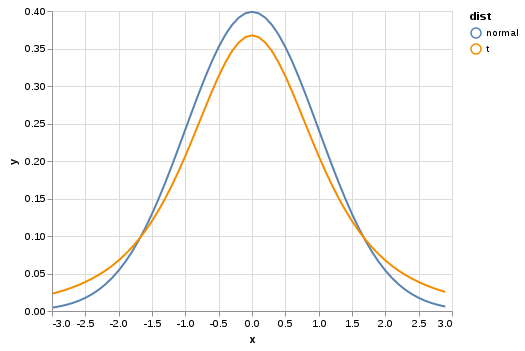

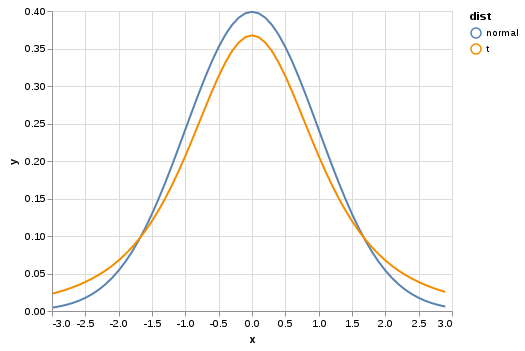

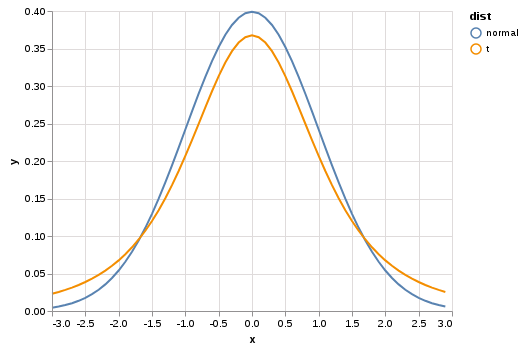

In [5]:
x=np.arange(-3,3,.1)
y=stats.norm.pdf(x)

y2=stats.t.pdf(x,df=3)
alt.Chart(pd.DataFrame({'x':x,'y':y,'dist':'normal'})).mark_line().encode(x='x',y='y',color='dist') + \
  alt.Chart(pd.DataFrame({'x':x,'y':y2, 'dist':'t'})).mark_line().encode(x='x',y='y',color='dist')

If you want a noncentral t distribution, note that it's a separate distribution in Python, `nct`;
it's _not_ a parameter to the t distribution like in R.

In [6]:
# You can see what parameters are available with .shapes:
stats.nct.shapes

'df, nc'

## Cumulative Distributions

In [7]:
stats.norm.cdf([-1.96,1.96])

array([0.0249979, 0.9750021])

In [8]:
# The inverse of the cdf is the Percent Point Function (actually 0 to 1, not a percent)
stats.norm.ppf([0.025,0.975])

array([-1.95996398,  1.95996398])

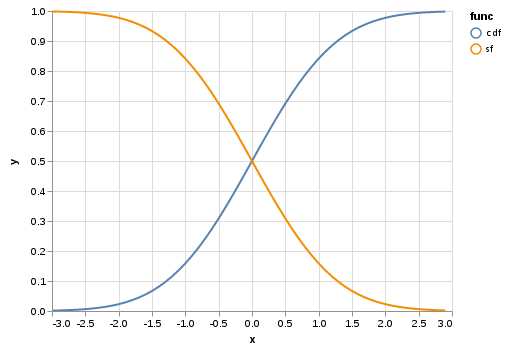

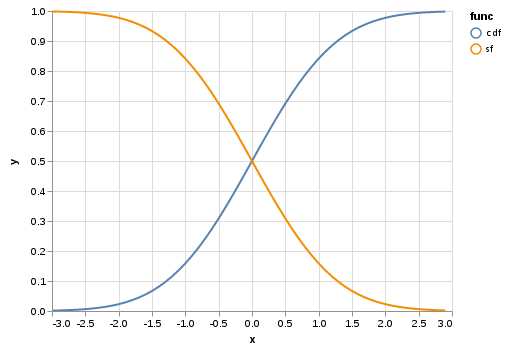

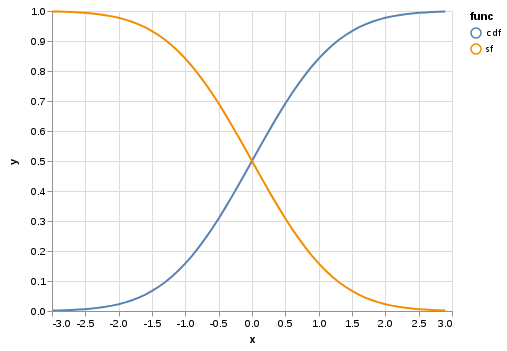

In [9]:
# The other tail is accessed as a separate function, sf()
x=np.arange(-3,3,.1)
alt.Chart(pd.DataFrame({'x':x,'y':stats.norm.cdf(x),'func':'cdf'})).mark_line().encode(x='x',y='y',color='func') + \
alt.Chart(pd.DataFrame({'x':x,'y':stats.norm.sf(x),'func':'sf'})).mark_line().encode(x='x',y='y',color='func')

## Discrete Distributions

In Python, discrete distributions have some differently named functions (pmf instead of pdf), but the cumulative functions are the same.

In [10]:
stats.binom.shapes

'n, p'

In [11]:
stats.binom.pmf(np.arange(0,5), 4,.5)

array([0.0625, 0.25  , 0.375 , 0.25  , 0.0625])

In [12]:
stats.binom.cdf(np.arange(0,5), 4,.5)

array([0.0625, 0.3125, 0.6875, 0.9375, 1.    ])

In [13]:
stats.binom.ppf([0.0625,0.3125,0.6875,0.9375,1], 4, .5)

array([0., 1., 2., 3., 4.])

In [14]:
stats.binom.ppf([0.3124,0.3125,0.3126], 4, .5)

array([1., 1., 2.])

In [15]:
# the other tail of the ppf is called the isf (inverse survival function)
stats.binom.isf([0.3124,0.3125,0.3126], 4, .5)

array([3., 2., 2.])

# Continuous Variable Tests


## Single Sample T-Test

The primary function here is `stats.ttest_1samp`.  Only a two-sided test is available; there is no one-sided option (you're expected to check the side and divide the p-value by 2 manually).

https://docs.scipy.org/doc/scipy/reference/tutorial/stats.html#t-test-and-ks-test

In [16]:
# Is the average bill statistically different from $20?
stats.ttest_1samp(tips.total_bill, popmean=20)

Ttest_1sampResult(statistic=-0.37559294451919506, pvalue=0.7075471935626723)

## Two-Sample T-Test

`stats.ttest_ind` (the "ind" is for "independent").  The only significant parameter is `equal_var` - if true, use pooled variance.  Unlike R, the default is _True_.

https://docs.scipy.org/doc/scipy/reference/tutorial/stats.html#comparing-two-samples

In [17]:
# Do men and women tip differently?
tips2 = tips.assign(tip_pct=tips.tip/tips.total_bill)
stats.ttest_ind(tips2[tips2.sex=='Male'].tip_pct,
                tips2[tips2.sex=='Female'].tip_pct, equal_var=False)

Ttest_indResult(statistic=-1.1432770167349968, pvalue=0.2542456188927583)

## Continuous Power Tests

http://www.statsmodels.org/stable/stats.html#power-and-sample-size-calculations

Parameters to `tt_ind_solve_power` are:
- effect_size
- nobs1
- alpha (significance level)
- power
- ratio (nobs2/nobs1), default 1

You must specify None for exactly one of the parameters, and it solves for that one.

This is very similar to R, except that instead of giving a delta and sd, you need to divide delta by sd and get the effect size yourself.  More conveniently than in R, you can have different values for n, and specify the _ratio_ between them, which is exactly what you want most of the time.

In [18]:
power.tt_ind_solve_power(effect_size=1, nobs1=None, ratio=1, alpha=0.05, power=0.95)

26.98920499749065

In [19]:
power.tt_ind_solve_power(effect_size=1, nobs1=10, ratio=1, alpha=0.05, power=None)

0.5620066386966457

There is also an analogous `zt_ind_solve_power`, using the z instead of t distribution.

## ANOVA

ANOVA requires a fitted linear regression object, so it will be covered with statsmodels instead of here.

# Discrete Variable Tests

## Single Sample Proportion Tests 

The Python implementation `proportions_ztest` offers a Z-test instead of R's $X^2$.  There is little or no practical difference in most situations.  The return values are:
- z statistic
- p value

https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportions_ztest.html

In [20]:
proportion.proportions_ztest(sum(tips.sex=='Male'), tips.shape[0], value=0.5)

(4.6779276972624935, 2.8978868440605785e-06)

There is also `binom_test`, which is exactly analogous to R's `binom.test`.  These use the binomial distribution instead of an approximation.

In [21]:
stats.binom_test(50,120)

0.08240747932752653

## Two Sample Proportion Tests

In [22]:
t=tips.groupby('smoker').aggregate({'sex':[('total','size'), ('male',lambda x: sum(x=='Male'))]})
t

sex     
       total male
smoker           
No       151   97
Yes       93   60

In [23]:
proportion.proportions_ztest(t.sex.male,t.sex.total)

(-0.04398657223093955, 0.9649151073157316)

## Chi-squared ($X^2$) tests

Remember that with a $X^2$ test, instead of a count of successes and totals, you use a count of successes and failures.

The return values from `chi2_contingency` are:
- chi^2 statistic
- p-value
- degrees of freedom
- expected values (array)

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html

In [24]:
t = tips.groupby(['sex','smoker']).size().unstack()
t

smoker,No,Yes
sex,,
Female,54,33
Male,97,60


In [25]:
# This is _surprisingly_ close to exactly independent:
stats.chi2_contingency(t,correction=False)

(0.001934818536627623, 0.964915107315732, 1, array([[53.84016393, 33.15983607],
        [97.15983607, 59.84016393]]))

Note that the implementation of the correction is not the same in Python as in R, so results will not match with correction.

In [26]:
# This may be more interesting:
stats.chi2_contingency(
    tips.groupby(['sex','time']).size().unstack(), correction=False)

(10.277251918677742,
 0.0013468039268008766,
 1,
 array([[ 62.75409836,  24.24590164],
        [113.24590164,  43.75409836]]))

In [27]:
# Of course we can also do more than 2x2 this way
stats.chi2_contingency(
    tips.groupby(['sex','day']).size().unstack(), correction=False)

(13.22200137240661,
 0.004180302092822257,
 3,
 array([[ 6.77459016, 31.0204918 , 27.09836066, 22.10655738],
        [12.22540984, 55.9795082 , 48.90163934, 39.89344262]]))

## Discrete Power Tests

There are functions available in statsmodels, not in scipy.  You'll need to compute your effect size yourself as a preprocessing step, like in R's pwr() library.

http://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportion_effectsize.html  
http://www.statsmodels.org/stable/generated/statsmodels.stats.power.NormalIndPower.html

In [28]:
# This is Cohen's standard -2*asin(sqrt(p)) effect size:
es=proportion.proportion_effectsize(0.1,0.2)
es

-0.2837941092083278

In [29]:
power.NormalIndPower().solve_power(es,power=0.95, alpha=0.05)

322.6931930526659

Don't be fooled by the functions called "tost".  That's actually the Two One Sided T-test function, which is a somewhat esoteric tool used for inverting the definition of null hypothesis and _rejecting_ the idea that two samples are _different_.  I just look at confidence intervals for that; I've never used the tost.

# Quantile-Quantile Plots

There's no convenient qqplot in Altair, so we'll use the one from matplotlib.

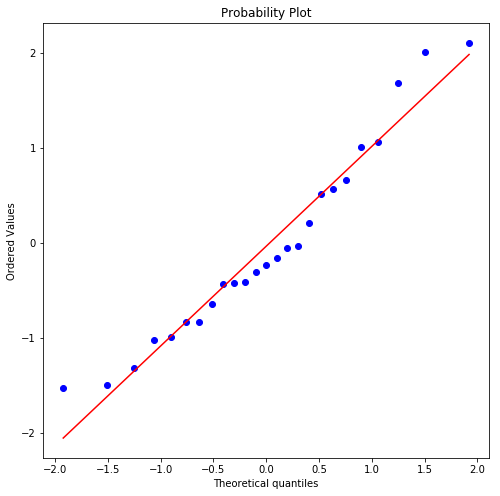

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [8,8]
stats.probplot(stats.norm().rvs(25),plot=plt)
plt.show()